In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
from tqdm import tqdm
import itertools
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Convolution1D, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
#from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


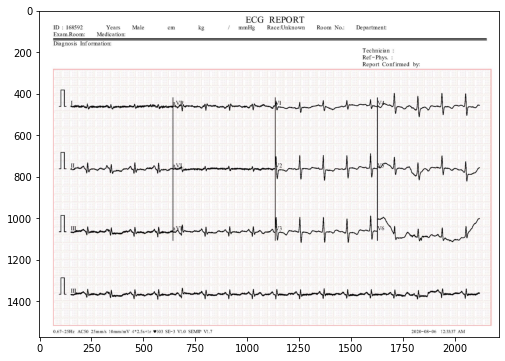

In [5]:
plt.figure(figsize=(14,6))
img=mpimg.imread('R:\MajorProject\Vital-Organ-HealthPredictor-v2-main\Vital-Organ-HealthPredictor-v2-main\ecgImage\Abnormal person ECG Images\HB   (2).jpg')
plt.imshow(img)

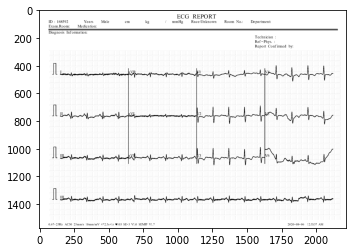

In [6]:
img1 = cv2.imread('R:\MajorProject\Vital-Organ-HealthPredictor-v2-main\Vital-Organ-HealthPredictor-v2-main\ecgImage\Abnormal person ECG Images\HB   (2).jpg', cv2.IMREAD_GRAYSCALE)
_, thresholded = cv2.threshold(img1, 127, 255, cv2.THRESH_BINARY)

plt.imshow(thresholded,cmap='gray')
plt.show()

In [9]:
dataset = []
for folder in ["R:/MajorProject/Vital-Organ-HealthPredictor-v2-main/Vital-Organ-HealthPredictor-v2-main/ecgImage/Abnormal person ECG Images/**","R:/MajorProject/Vital-Organ-HealthPredictor-v2-main/Vital-Organ-HealthPredictor-v2-main/ecgImage/Normal Person ECG Images (859)/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split()[0]
                
            if label in ["HB", "MI", "PMI"]:
                            dataset.append({
                                "filename": filename,
                                "label": "abnormal",
                                
                            })
            else:
                            dataset.append({
                                "filename": filename,
                                "label": "normal",
                            })
                        
dataset = pd.DataFrame(dataset)
#dataset = shuffle(dataset, random_state=42)
dataset.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1682 non-null   object
 1   label     1682 non-null   object
dtypes: object(2)
memory usage: 26.4+ KB


In [10]:
dataset

,filename,label
0,R:/MajorProject/Vital-Organ-HealthPredictor-v2...,abnormal
1,R:/MajorProject/Vital-Organ-HealthPredictor-v2...,abnormal
2,R:/MajorProject/Vital-Organ-HealthPredictor-v2...,abnormal
3,R:/MajorProject/Vital-Organ-HealthPredictor-v2...,abnormal
4,R:/MajorProject/Vital-Organ-HealthPredictor-v2...,abnormal
...,...,...
1677,R:/MajorProject/Vital-Organ-HealthPredictor-v2...,normal
1678,R:/MajorProject/Vital-Organ-HealthPredictor-v2...,normal
1679,R:/MajorProject/Vital-Organ-HealthPredictor-v2...,normal
1680,R:/MajorProject/Vital-Organ-HealthPredictor-v2...,normal


array([[  0.        , 153.        ],
       [  1.        , 204.        ],
       [  2.        , 255.        ],
       [  3.        , 255.        ],
       [  4.        , 255.        ],
       [  5.        , 254.98671875],
       [  6.        , 254.5421875 ],
       [  7.        , 253.8578125 ],
       [  8.        , 252.9125    ],
       [  9.        , 252.09765625],
       [ 10.        , 251.31328125],
       [ 11.        , 250.84453125],
       [ 12.        , 250.65390625],
       [ 13.        , 250.69296875],
       [ 14.        , 250.496875  ],
       [ 15.        , 250.28125   ],
       [ 16.        , 250.10625   ],
       [ 17.        , 249.78125   ],
       [ 18.        , 249.6875    ],
       [ 19.        , 249.3515625 ],
       [ 20.        , 248.97421875],
       [ 21.        , 248.8546875 ],
       [ 22.        , 248.93203125],
       [ 23.        , 248.7859375 ],
       [ 24.        , 249.22265625],
       [ 25.        , 249.8109375 ],
       [ 26.        , 250.2296875 ],
 

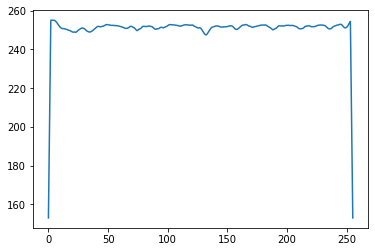

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load ECG image
img = cv2.imread("R:\MajorProject\Vital-Organ-HealthPredictor-v2-main\Vital-Organ-HealthPredictor-v2-main\ecgImage\Abnormal person ECG Images\HB   (2).jpg", 0)

#Resize image
target_size=(256,256)
img = cv2.resize(img,target_size)

# Pre-processing: Perform image enhancement techniques
img = cv2.medianBlur(img, 5)
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

# Segmentation: Locate the ECG waveform in the image
_, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
ROI = max(contours, key=cv2.contourArea)

# Resampling: Resample the ECG image to a 1D signal
y = cv2.polylines(img, [ROI], False, 255, 1)
y = np.mean(y, axis=0)
y = y.astype(np.float32)
x = np.arange(0, len(y))

# Denoising: Apply denoising techniques
y = np.convolve(y, np.ones(5)/5, mode='same')

# Data representation: Represent the 1D ECG signal

z=plt.plot(x, y)[0]
xdata = z.get_xdata()
ydata = z.get_ydata()
z_array = np.array([xdata, ydata]).T
z_array

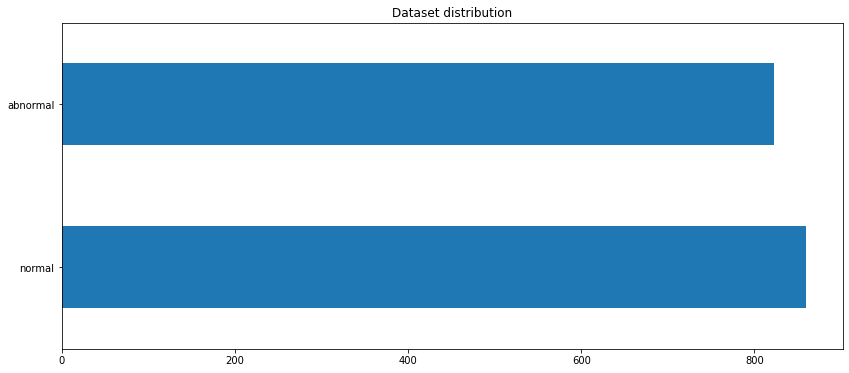

In [13]:
plt.figure(figsize=(14,6))
dataset.label.value_counts().plot(kind='barh', title="Dataset distribution")
plt.show()

In [14]:
def extract_features(image_path):
    # Load ECG image
    img = cv2.imread(image_path)

    #Resize image
    target_size=(256,256)
    img = cv2.resize(img,target_size)
    
    # Pre-processing: Perform image enhancement techniques
    img = cv2.medianBlur(img, 5)
    img = cv2.normalize(img, None, 0, 256, cv2.NORM_MINMAX)

    # Segmentation: Locate the ECG waveform in the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to grayscale
    _, thresh = cv2.threshold(img, 127, 256, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    ROI = max(contours, key=cv2.contourArea)

    # Resampling: Resample the ECG image to a 1D signal
    y = cv2.polylines(img, [ROI], False, 255, 1)
    y = np.mean(y, axis=0)
    y = y.astype(np.float32)
    x = np.arange(0, len(y))

    # Denoising: Apply denoising techniques
    y = np.convolve(y, np.ones(5)/5, mode='same')
    z=plt.plot(x, y)
    z=plt.plot(x, y)[0]
    xdata = z.get_xdata()
    ydata = z.get_ydata()
    z_array = np.array([xdata, ydata]).T
    
    return z_array

In [15]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 1345
Test: 337


100%|██████████| 337/337 [00:19<00:00, 17.40it/s]


X train: (1345, 256, 2)
X test: (337, 256, 2)


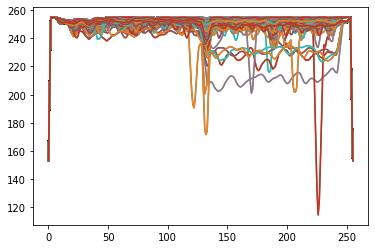

In [16]:
from tqdm import tqdm
x_train = []
x_test = []

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx]))
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)
  

print("X train:", x_train.shape)
print("X test:", x_test.shape)

In [17]:
y_train = train.label
y_test = test.label
y_test

1393      normal
743     abnormal
1605      normal
49      abnormal
188     abnormal
          ...   
226     abnormal
231     abnormal
651     abnormal
1432      normal
700     abnormal
Name: label, Length: 337, dtype: object

In [18]:
y_train

163     abnormal
522     abnormal
575     abnormal
266     abnormal
148     abnormal
          ...   
1130      normal
1294      normal
860       normal
1459      normal
1126      normal
Name: label, Length: 1345, dtype: object

In [19]:
encoder = LabelEncoder()
y_train=encoder.fit_transform(y_train)
y_test=encoder.transform(y_test)

In [20]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [21]:
y_test

array([1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [22]:
y_train = np.reshape(y_train, (-1, 1))

# Verify the shape of x_train and y_train
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (1345, 256, 2)
y_train shape: (1345, 1)


In [23]:
y_test = np.reshape(y_test, (-1, 1))

# Verify the shape of x_train and y_train
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_test shape: (337, 256, 2)
y_test shape: (337, 1)


In [24]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Reshape the training and test data
x_train_flat = np.reshape(x_train, (x_train.shape[0], -1))
x_test_flat = np.reshape(x_test, (x_test.shape[0], -1))

# Create a random forest classifier and fit it to the training data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_flat, y_train.ravel())

# Evaluate the model on the test data
accuracy = rf.score(x_test_flat, y_test.ravel())
print("Test accuracy:", accuracy)


Test accuracy: 0.7833827893175074


In [30]:
import pickle

with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf, f)
    f.close()



In [31]:
with open('random_forest_model.pkl', 'rb') as f:
    rf_loaded = pickle.load(f)


x_new shape: (1, 256, 2)


array([0])

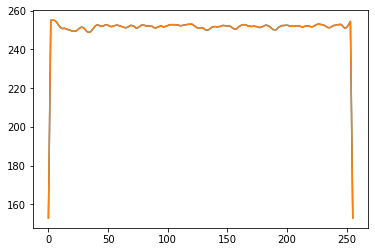

In [33]:
classify_file ="R:\MajorProject\Vital-Organ-HealthPredictor-v2-main\Vital-Organ-HealthPredictor-v2-main\ecgImage\Abnormal person ECG Images\HB   (1).jpg"
x_new=[]
x_new.append(extract_features(classify_file))
# x_new = np.reshape(x_new,1,512)
#x_new_flat = np.reshape(x_new, (x_new.shape[0], -1))
# # Verify the shape of x_train and y_train
x_new = np.array(x_new)
print("x_new shape:", x_new.shape)
x_new_flat = np.reshape(x_new, (x_new.shape[0], -1))
x_new_flat.shape
y_pred = rf_loaded.predict(x_new_flat)
y_pred
# x_new


In [34]:
y_pred
y_original = encoder.inverse_transform(y_pred)
y_original
if y_original == 'normal':
    print("The ECG is normal.")
else:
    print("The ECG is abnormal.")

The ECG is abnormal.
